#### Import packages

In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn') 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import shutil
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import random
import cv2

import itertools
import math
import time
from IPython import display

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.utils.data as data_utils
import torchvision.transforms as transforms

seed = 0
# random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
np.random.seed(seed)
from utils import *

#### Load and Prepare Data

In [2]:
data = pd.read_json('./Data/train.json')
test = pd.read_json('./Data/test.json')

In [3]:
data['band_1'] = data['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

test['band_1'] = test['band_1'].apply(lambda x : np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x : np.array(x).reshape(75, 75))

In [4]:
def scale_range (input_, min_, max_):
    input_ += -(np.min(input_))
    input_ /= np.max(input_) / (max_ - min_)
    input_ += min_
    return input_

In [5]:
band_1_tr = np.concatenate([im for im in data['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in data['band_2']]).reshape(-1, 75, 75)
X_Real_std = np.stack((band_1_tr, band_2_tr), axis=1)
X_Real = np.stack((band_1_tr, band_2_tr), axis=1)
# # X_Real = band_1_tr
X_Real = (X_Real-X_Real.mean(axis=0))/X_Real.std(axis=0)

# band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
# band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
# X_test = np.stack((band_1_test, band_2_test), axis=1)

y_Real = data['is_iceberg'].values.astype(np.float32)

# Keep only icebergs/ships
X_Real = scale_range(X_Real[np.where(y_Real==0)], -1, 1)
y_Real = y_Real[np.where(y_Real==0)]

In [6]:
# Data Loader (Input Pipeline)
class icebergDataset(data_utils.Dataset):
    """Iceberg-Ship dataset."""

    def __init__(self, X, y=None):
        self.X_images = X
        if y!=None:
            self.y = torch.from_numpy(y).long()
        else:
            self.y=None

    def __len__(self):
        return len(self.X_images)

    def __getitem__(self, idx):
        im = self.X_images[idx]
        im = torch.from_numpy(im).float()
        
        try:
            if self.y==None:
                return im
        except:
            pass
        
        return [im, self.y[idx]]
    
real_ds = icebergDataset(X_Real, y_Real)
train_loader = torch.utils.data.DataLoader(real_ds, batch_size=32, shuffle=True, drop_last=True)

/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


## My first GAN!!
#### Adapted from: https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb

In [7]:
# Hyper Parameters
width = 75
height = 75
channels = 2
padding = 0

In [8]:
act = nn.LeakyReLU(0.2, inplace=True)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.batch = nn.BatchNorm2d(channels)
        self.layer1 = nn.Sequential(
            nn.Conv2d(channels, 9, kernel_size=3, padding=padding),
            nn.BatchNorm2d(9),
            act,
            nn.Conv2d(9, 18, kernel_size=3, padding=padding),
            nn.BatchNorm2d(18),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(18, 24, kernel_size=3, padding=padding),
            nn.BatchNorm2d(24),
            act,
            nn.Conv2d(24, 36, kernel_size=3, padding=padding),
            nn.BatchNorm2d(36),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(36, 72, kernel_size=2, padding=padding),
            nn.BatchNorm2d(72),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(72, 144, kernel_size=2, padding=padding),
            nn.BatchNorm2d(144),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.fc1 = nn.Sequential(
            nn.Linear(3*3*144, 512),
            act,
            nn.Dropout(0.5))
        self.fc2 = nn.Sequential(
            nn.Linear(512, 196),
            act,
            nn.Dropout(0.3))
        self.fc3 = nn.Sequential(
            nn.Linear(196, 1),
            nn.Sigmoid())
    
    def forward(self, x):
#         x = self.batch(x)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [9]:
act = nn.LeakyReLU(0.2, inplace=True)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(100, 1024))
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 2048))
        self.fc3 = nn.Sequential(
            nn.Linear(2048, 4*4*2*128))
        self.layer1 = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(128))
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=1),
            nn.BatchNorm2d(64))
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
#             act,
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=padding),
            nn.BatchNorm2d(16))
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(8),
#             act,
            nn.Conv2d(8, 2, kernel_size=3, padding=padding),
#             nn.BatchNorm2d(2),
            nn.Tanh())
        
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = out.view(out.size(0), 256, 4, 4)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [10]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(75*75*2, 2048),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(2048, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         out = self.model(x.view(x.size(0), 75*75*2))
#         out = out.view(out.size(0), -1)
#         return out

In [11]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(100, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 2048),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(2048, 75*75*2),
#             nn.Tanh()
#         )
    
#     def forward(self, x):
#         x = x.view(x.size(0), 100)
#         out = self.model(x)
#         out = out.view(out.size(0), 2, 75, 75)
#         return out

In [12]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()

### Optimization

In [13]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Training

In [14]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [15]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [16]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100).cuda())

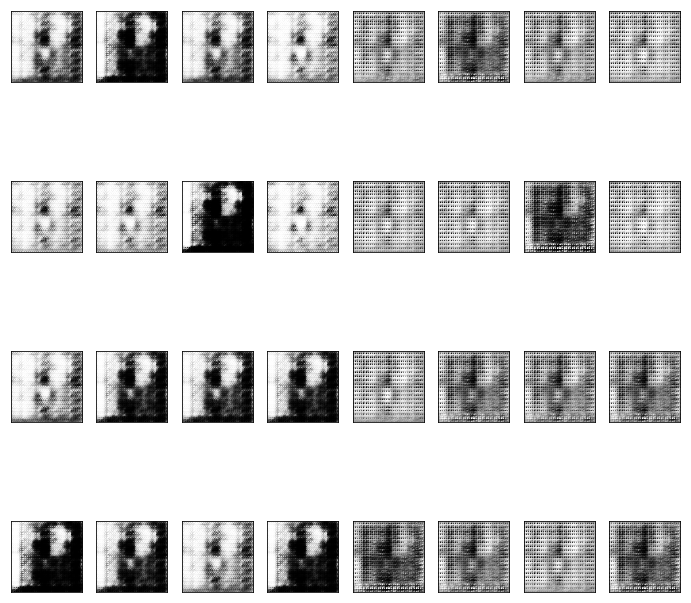

Epoch [65/200], Step[26/26], d_loss: 0.6912, g_loss: 4.8208, D(x): 0.90, D(G(z)): 0.14


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-c13b60ac2110>", line 38, in <module>
    ax[i,j].cla()
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axes/_base.py", line 984, in cla
    spine.cla()
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/matplotlib/spines.py", line 170, in cla
    self.axis.cla()
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axis.py", line 760, in cla
    self.reset_ticks()
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axis.py", line 774, in reset_ticks
    self.majorTicks.extend([self._get_tick(major=True)])
  File "/home/arsh/anaconda3/envs/torch/lib/python3.6/site-packages/matplotlib/axis.py", line 1729, in _get_tick
    return XTick(self.axes, 0, '', 

KeyboardInterrupt: 

In [17]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid*2, figsize=(12, 12))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid*2)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, labs) in enumerate(train_loader):
        images = Variable(images.cuda())
        real_labels = Variable(torch.ones(images.size(0), 1).cuda())
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
    test_images = generator(test_noise)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(2, 75, 75)[0], cmap='gray')
        ax[i,j+4].imshow(test_images[k,:].data.cpu().numpy().reshape(2, 75, 75)[1], cmap='gray')
                
    display.clear_output(wait=True)
    display.display(plt.gcf())
            
#             plt.savefig('results/mnist-gan-%03d.png'%num_fig)
    num_fig += 1
    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
            'D(x): %.2f, D(G(z)): %.2f' 
            %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
            real_score.data.mean(), fake_score.data.mean()))

fig.close()

In [ ]:
def save_checkpoint(state, is_best, filename='./Models/checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, './Models/GAN_ship_model_best.pth.tar')

In [19]:
save_checkpoint({
    'epoch': 55,
    'state_dict': generator.state_dict(),
    'best_prec1': 0.5,
}, 1)

In [20]:
best_model = torch.load('./Models/GAN_ship_model_best.pth.tar')
generator.load_state_dict(best_model['state_dict'])

In [21]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100).cuda())

In [22]:
test_images = generator(test_noise)

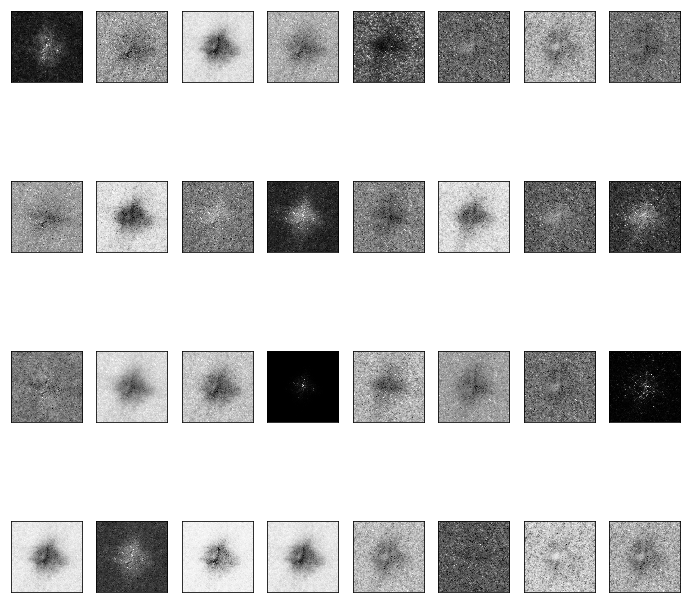

In [23]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid*2, figsize=(12, 12))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid*2)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(2, 75, 75)[0], cmap='gray')
    ax[i,j+4].imshow(test_images[k,:].data.cpu().numpy().reshape(2, 75, 75)[1], cmap='gray')
display.display(plt.gcf())